# 第七章 外部工具调用
## 7.1 简介

### 7.1.1 什么是工具和外部工具调用

大型语言模型（Large Language Models, LLMs）已经展现出强大的自然语言理解和生成能力,它们可以流畅地撰写文章、回答问题、总结文献，甚至能模仿不同写作风格，展现出近似人类的语言理解与生成能力。这一能力的背后，是对海量文本数据的深度学习和对语言结构的高度建模。然而，这些模型在推理时依靠的是语言和统计概率，而不是实际的逻辑推演或数值运算模块，它们依然存在 **知识闭合**、**计算不精确**、**无法与外界交互** 等关键限制。这些关键限制条件，恰恰决定了语言模型能否成为一个真正有用的“智能体（Agent）”。在现代应用中，用户需要的不只是听得懂的助手，而是一个能够主动感知、判断、行动的智能代理，这也正是为什么外部工具调用成为当代智能体系统进化的关键一步。

设想以下几个场景：                                       

- “上海今天会下雨吗？” → LLM可能无法提供实时天气，因为其训练数据已过时；
- “123456789 × 987654321 等于多少？” → 模型往往给出错误答案，因为其内部没有精确计算模块；
- “请帮我打开家里的灯” → 模型无法真正控制物理设备，因为它并不具备执行能力。

这些例子说明，**纯语言模型并不足以胜任复杂任务**。为了解决这些问题，AI Agent 开始演化出一种关键能力：**调用外部工具（External Tool Calling）**。这一机制使模型能突破“语言模型”边界，成为真正具备“行动能力”的智能体。

比如，当你请求一个大模型“请翻译这张图片中的文字”时，传统的大模型只能依赖自身训练时学到的知识，进行猜测式的“盲目推理”。但如果我们为模型接入图像识别或翻译类工具，它就可以先调用识别模块获取图片中的文字内容，再借助翻译 API 进行处理，从而生成更准确、更专业的翻译结果。
外部工具调用（Tool Calling）便指的是模型在回答问题或完成任务过程中，能够：

1. **判断自身是否需要帮助**；
2. **调用某种外部能力**（如搜索引擎、计算器、数据库、设备控制接口）；
3. **解析工具返回结果**，继续完成任务。

这种能力使智能体不再局限于凭已有的知识进行猜测，而是可以像人一样通过查询资料、计算结果、发出对应的指令，大大提升了解决实际问题的可靠性和实用性。

当前学术界对于“工具（Tool）”的定义尚未形成统一共识，但普遍的观点认为：凡是能够作为模块化接口，使语言模型得以从外部获取或操作知识、执行计算任务、访问系统资源的组件，皆可被视作工具。这些工具形态多样，可以是文本检索引擎、Python 解释器、地图或天气类 API，甚至是可与数据库交互的接口等。


### 7.1.2 工具调用的核心流程

下面是一个工具调用流程的示意图：

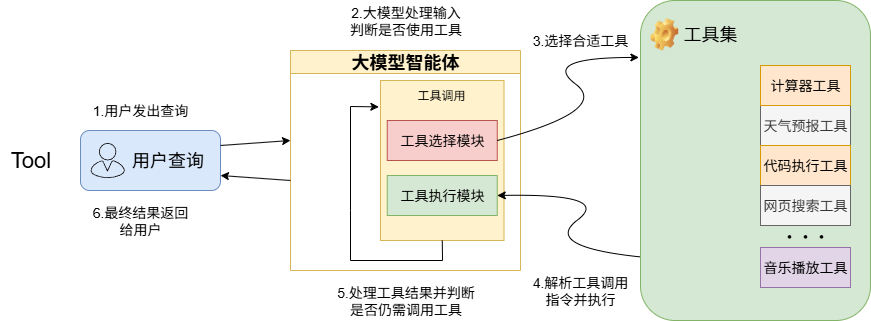
<center style="font-size:14px">图1.工具调用流程示意图</center> 

这个流程体现了智能体如何动态决策是否调用工具，并将外部能力集成到完整的任务解决链中。


这通常需要我们以合理的方式设计：

- 工具的接口描述（让模型知道有哪些工具可选）；
- 使用格式（让模型学会如何正确发出指令）；
- 调用时机（判断何时需要调用，何时直接回答）；
- 结果反馈（如何使用工具返回结果继续完成任务）。

因此，工具调用背后是一整套 **“感知—思考—行动”** 的机制，而不仅仅是运行一个函数。

让我们通过一个具体例子看懂工具调用的实际效果：

**问题：** “上海现在的天气怎么样？”

**非工具增强LLM：** “对不起，我无法访问最新天气数据。”

**工具增强LLM（Agent）：**

1. “识别信息不足；”
2. “生成调用指令，搜索网页信息`；”
3. “执行指令，获取网页信息；”
4. “提取结果并回复：‘当前温度 24° · 多云，下面是对上海未来一周天气的简要解读及建议：’”

通过引入“搜索引擎”这个工具，模型的回答就从“我不知道”变成了正确的实时数据。


### 7.1.3 本章重点

我们将在本章中循序渐进介绍如下内容：

1. 工具调用的必要性与基本概念；
2. 不同类型的常见工具及其使用场景；
3. 如何向模型描述并注册工具；
4. 如何判断是否应使用工具；
5. 多工具调度与整合；
6. 实战项目：构建具备搜索与计算能力的问答智能体。

本章的学习目标是：让你能够设计、实现并理解一个可调用多种工具的智能体系统，并通过动手实践掌握如何构建具身化的AI智能体。

## 7.2 引入外部工具的必要性

在实际应用中，尽管大语言模型（LLM）已经展现出惊人的语言理解与生成能力，但我们仍然无法将它视为“通用智能体”。原因在于，它们的推理边界和能力瓶颈，在面对真实世界的任务时暴露得尤为明显。Tool Calling 的价值远不止于给模型加一个插件那么简单，它在扩展大语言模型能力边界方面具有深远意义，主要体现在以下几个方面：
1. 外部知识获取：工具赋能让语言模型能够访问实时信息，解决知识更新滞后的问题。
2. 专业技能扩展：借助专业工具，模型在复杂或垂直领域任务中的表现显著增强。
3. 自动化任务执行：通过调用执行型工具，模型可主动完成操作任务，实现从生成到行动的跃迁。
4. 多模态理解能力：多模态工具使模型能处理图像、语音等非文本信息，扩展输入理解的边界。
5. 可解释性与信任提升：显式调用流程提升了模型行为的透明度，增强用户的可控性与信任感。
6. 系统鲁棒性与拓展性：模块化工具结构支持灵活扩展与替换，提升系统适应复杂环境的能力。

接下来，我们分别从几个方面通过实例来展示纯大语言模型的天然局限性以及引入外部工具的必要性。

### 7.2.1 大语言模型的局限性
1. 模型知识是静态的、封闭的  

大语言模型的知识来源于训练语料库，这些语料库虽然庞大，但具有两个问题：

- **不可更新**：模型一旦训练完成，其知识就被“冻结”。例如，一个2023年训练的模型肯定无法得知2025年发布的新闻。
- **范围有限**：即便拥有大规模的数据，也难以把领域特定或时效性极强的信息全部包括进去。
这样便导致在如天气查询、股票价格、新闻事件、实时交通等领域的问题上，纯大语言模型无法做到

例子：  
**问题：** “上海现在的天气怎么样？”  
LLM回答：“今天上海天气晴”  
工具调用的LLM：`GET_WEATHER["Shanghai"]` → “当前为多云转阴，气温28℃”


2. 缺乏高精度计算能力  
大语言模型在记忆和推理方面能力强，但它们不具备真正的“计算能力”。在如大数乘法、科学计数、公式推导、代码执行、单位换算等需要精确计算的数学问题上，模型生成的回答经常出错。因为即使提示它认真算，它的计算过程也只是文本生成过程的一部分，不具备确定性和精确性。纯大语言模型的数学运算只是在进行文本生成而非真实计算，难以胜任高位数、带单位或逻辑性强的计算任务。

例子：  
**问题：** “17273 × 947等于多少？”  
LLM计算：“17273 × 947 = 16357631” （错误）  
工具调用：`CALC[17273 * 947]` → 16357531 


3. 无法操作现实设备或系统  
设想一个 AI 生活助理的对话：用户发出指令“帮我订一张明天下午去上海的高铁票”。普通的大语言模型可能会这样回答：“您可以通过 12306 进行购票。”这听起来有帮助，但是实际上什么都没做。它仅仅是将其知识中有关订购高铁票的知识告诉给你，但是无法主动去做事情。对于纯大语言模型来说，它只能说不能做，即便模型“知道”某个操作如何执行，它也无法直接影响外部世界。而对于一个真正的智能体，对于这样的用户指令应该能首先调用火车查询的API，然后解析车次与余票，接着向用户提出建议并完成下单或提醒用户操作。这需要的不只是语言生成，而是系统级调用与实际执行能力。

### 7.2.2 能力补全的关键路径

我们可以把外部工具理解为语言模型的“感官”和“肌肉”。在传统模式下，语言模型的知识来源仅限于其训练时所接触到的文本数据。这种知识是静态的、滞后的，无法涵盖实时信息。因此，引入外部工具，使大模型从单一的大脑体，升级为具备完整感知—决策—行动闭环的智能体。这正是智能体与传统LLM的分水岭所在。外部工具的加入，为大语言模型提供了三种关键能力补全：

| 层次 | 原始能力 | 工具增强后的能力 |
|------|-----------|------------------|
| 感知 | 只能回忆训练知识 | 实时获取环境信息（如搜索引擎、数据库） |
| 推理 | 容易出错的“语言计算” | 借助工具获得精确结论（如计算器、代码解释器） |
| 行动 | 无执行能力 | 控制系统与设备（如日历、摄像头、机器人） |

这些增强使得大语言模型不再是“独立大脑”，而是成为了真正的智能Agent —— 具备观察力、执行力、适应性的智能系统。从某种意义上说，“工具调用”机制是让大语言模型从“模拟智能”向“具身智能”迈出第一步。

### 7.2.3 实验部分
接下来是一个小型的实验，代码中已经预先定义好了一个以开源大模型为核心的agent（采用的是qwen2.5-0.5B模型），并实现了一个简单的对话代码。你可以运行代码看看大模型是否能给出正确的计算结果。同时，你也可以自由的更改system_prompt内容和你的question进行实验，看看是否会有不一样的结果。

1. 定义智能体(你可以把其中Qwen2.5-0.5B-Instruct换成其他开源模型再次尝试)

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

class QWenAgent:
    def __init__(self, system_prompt="你是一个很聪明的智能体。"):
        self.tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)
        self.model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", device_map="auto", trust_remote_code=True)
        self.system_prompt = system_prompt
        self.messages=[
            {"role": "system", "content": system_prompt}
        ]
        self.model.eval()

    # 提问接口
    def chat(self, question):
        self.messages.append({"role": "user", "content": question})
        input_ids = self.tokenizer.apply_chat_template(self.messages,tokenize=False,add_generation_prompt=True)
        inputs = self.tokenizer(input_ids, return_tensors="pt", truncation=True, max_length=2048).to(self.model.device)
        outputs = self.model.generate(**inputs, 
                                max_new_tokens=200, 
                                do_sample=True,      # 开启采样
                                temperature=0.7,     # 可调节生成的多样性
                                top_p=0.9)  # 禁用采样，使用贪婪搜索
        response = outputs[0][inputs['input_ids'].shape[1]:]  # 只保留生成的新 token
        answer = self.tokenizer.decode(response, skip_special_tokens=True)
        return answer # 返回智能体的回答
    
    # 更新系统提示词
    def update_system_prompt(self, system_prompt):
        self.system_prompt = system_prompt


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. 测试问题回答

In [2]:
import sys
import os


system_prompt="你是一个很聪明的智能体。"
qwenagent = QWenAgent(system_prompt)

question = "17273 × 947等于多少？"
answer = qwenagent.chat(question)
print(answer)

/usr/local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


\(17273 \times 947 = 1650411\).


## 7.3 常见工具类型及应用场景

在前一节中我们已经明确了工具调用的必要性以及工具的定义，那么智能体究竟可以调用哪些工具？每种工具又适用于什么样的任务？其关键在于明白每种工具背后的设计目的和适用边界。

目前的工具可以按照功能划分为以下几个类别：
1. 信息检索类工具
如网页搜索引擎、数据库查询接口。智能体遇到知识性问题时可使用此类工具获取外部信息。
2. 计算与执行类工具
如计算器、代码执行器。当需要数学运算或运行代码时，智能体可调用计算引擎或编程环境完成任务。
3. 设备控制类工具
如调用操作系统命令、发送邮件、控制物联网设备等，使智能体能对现实世界产生影响（此类用例需严格权限控制）。

本节将从实用性出发，围绕这三类工具进行讲解，包括每种工具的典型应用场景，也包括它们在智能体系统中的调用方式与注意事项，帮助你对工具生态形成完整的理解框架，为后续构建可用、可靠、灵活的智能体系统打下坚实基础。




### 7.3.1 信息检索类工具


信息检索类工具主要解决的核心问题是模型不知道的问题。尽管大语言模型通过大规模训练学到了大量通识性知识，但它的“知识边界”总是固定在训练时刻。

信息检索工具好比是随时能查阅的图书馆。它们允许模型访问**模型知识库之外的内容**，包括：

- 实时信息：如今天的天气、当前的股市行情、最新新闻动态、汇率变动。这类信息随时变化，模型在训练时可能并未接触，且无法预测。
- 长尾知识：如一项偏门技术的API文档、某地的冷门旅游景点。这类知识往往存在于长尾分布中，即使模型见过类似内容，也很可能记不准确。
- 用户个性化数据：如用户的购物记录、个人日程安排、企业内部数据库等。这类数据具有隐私性和时效性，天然无法作为训练语料被模型预先学习。

这三类内容共同构成了“语言模型自身知识的盲区”。信息检索类工具正是用来弥补这一盲区的桥梁，智能体在面对问题时，可以调用这些工具主动发出查询请求。

常见代表性的工具如下所示：

| 工具类型       | 示例                                 | 说明                             |
|----------------|--------------------------------------|----------------------------------|
| 网页搜索       | Bing Search API、Google Custom Search| 获取实时网页信息                 |
| 文档查询       | PDF QA、RAG 查询系统                 | 从上传的文档中检索回答           |
| 数据库查询     | SQL API、Mongo Query Tool            | 结构化数据访问                   |
| 代码检索       | Github Search、DocIndex              | 搜索开源代码或API文档            |

我们来考虑以下的场景

**任务 1：** “请告诉我2024年诺贝尔物理学奖的获奖者”

- 模型本身不知道，因为训练数据截止于某一时间。
- 智能体可以自动发出：`SEARCH[2023 Nobel Prize Physics]`
- 检索网页后提取信息：“Pierre Agostini、Ferenc Krausz 和 Anne L’Huillier 因阿秒物理获奖”

**任务 2：** “从这份公司财报中找出净利润同比变化”

- 上传文档后，模型调用向量检索+OCR等工具解析PDF
- 使用文档QA插件返回答案：“同比增长5.6%”

但是存在以下的注意事项：

- 网页搜索结果需要进一步抽取或总结，否则容易出现“直接复制网页”的生硬回答；
- 多数RAG系统需搭配向量数据库使用，推荐结合FAISS、Chroma、Weaviate等工具构建；
- 查询类工具不保证100%相关，因此需要模型具备“摘要与判断能力”。


### 7.3.2 计算与执行类工具


大语言模型虽然能用自然语言描述代码逻辑，但它的推理过程本质上是基于语言概率的预测，而不是程序性的执行。这就意味着，一旦任务涉及精确运算、严谨推理或实际运行环境便会出现问题。为了解决这一能力缺口，我们引入了计算与执行类工具，提供的是语言模型本身无法胜任的精确操作，包括但不限于：

- 数值计算：如高精度乘除、浮点数运算、排列组合概率、矩阵操作等；
- 逻辑推理：如数独、逻辑谜题、图结构路径寻找；
- 代码运行与调试：将用户描述转化为代码后进行执行，并根据输出再调整；
- 文件处理：如读取CSV文件、生成统计图表、提取图像特征或读取PDF文本。

这些操作不仅需要语义理解，更需要计算能力或真实运行环境支撑。这类工具让模型从语言生成者进化为任务求解器。

常见代表性的工具如下所示：

| 工具类型        | 示例                                 | 功能描述                     |
|-----------------|--------------------------------------|------------------------------|
| 计算器引擎      | Wolfram Alpha、Python Eval、mathjs  | 精确数学计算、表达式解析     |
| 代码执行器      | Code Interpreter、Jupyter Kernel     | 执行任意 Python 代码         |
| 文件处理器      | CSV reader、Pandas toolkit           | 文件分析与处理               |
| 模型执行器      | Sklearn、HuggingFace API 调用       | 执行训练模型进行推理         |

我们来考虑以下的场景：

**任务 1：** “给定方程 2x² + 3x - 5 = 0，求解 x”

- 传统 LLM 可能列出解法，但容易计算错误；
- 增强智能体可以发出：`CALC[solve(2*x**2 + 3*x - 5 = 0)]`
- 得到结果：x ≈ 0.8508 或 x ≈ -2.8508

**任务 2：** “请帮我读取 sales.csv，并输出销售额最高的城市”

- 解析上传的CSV后，模型调用 Pandas 工具，运行以下代码：
```python
df = pd.read_csv('sales.csv')
result = df.groupby('city')['sales'].sum().idxmax()
```

返回结果：“北京是销售额最高的城市，总销售为 123,456 元。”

但是存在以下的注意事项：

- 代码执行器可能存在安全风险，因此实际部署中需要进行“沙箱隔离”；

- 工具接口必须有明确的输入输出格式（如 JSON），防止模型生成不规范指令；

- 大模型生成代码的能力虽强，但在任务长链中仍需验证与调试。

### 7.3.3 设备控制类工具

设备控制类工具使得智能体**不再局限于语言交互**，而是能够操控真实系统与设备，具备“动作能力”。设想你和一个AI助手说：“把下周五的面试添加到日历上，并给我发个提醒。”
这些请求已经不是单纯的信息问答，而是真实的动作执行。语言模型要完成这些任务，必须能通过工具调用访问操作系统、连接设备、发出指令。

这类工具主要作用包括：

- 操作系统控制：如打开、编辑、保存文件，运行本地脚本，管理文件结构
- 设备远程控制：如控制灯光、电器、安防系统，甚至遥控机械臂、机器人
- 消息发送与事务处理：如添加日程、发送提醒、通知他人、下单购物等自动化事务执行


常见代表性的工具如下所示：

| 工具类型   | 示例                                  | 应用说明                           |
|------------|---------------------------------------|------------------------------------|
| 命令行接口 | Shell API、Subprocess runner         | 执行系统命令（需权限控制）         |
| 邮件工具   | Gmail API、SMTP client               | 发送通知邮件                       |
| 日历管理   | Google Calendar API                  | 创建、更新会议日程                 |
| IOT 控制   | Home Assistant、Matter、MQTT 控制器 | 控制智能灯、空调、摄像头等设备     |


我们来考虑以下的场景：  
**任务 1**： “请每天 8 点提醒我喝水”

- 智能体发出计划指令：CALENDAR[create_event(time=8:00, text="喝水提醒")]

- 使用 Calendar API 自动注册事件

**任务 2**： “请帮我打开会议室灯光并调暗至30%”

- 智能体解析意图后生成：
- IOT[device="meeting_light", action="set_brightness", value=30]

- 控制命令通过 MQTT 或 Home Assistant 发送到设备

但是存在以下的注意事项：

 - 设备控制属于高权限操作，应有明确权限验证与审核流程；
 - 某些操作（如发邮件、开关电源）可能涉及安全或法律风险；






## 7.4 如何选择并使用工具

前几节我们已经明确：引入外部工具可以显著扩展语言模型的能力边界，使其能够查询最新信息、执行复杂计算、与真实世界互动。然而，“有工具”并不等于“会用工具”。现实中我们发现，即使为语言模型提供了丰富的工具能力，仍然会频繁出现以下问题：

- 模型根本不知道有工具可以使用；
- 模型调用了错误的工具
- 模型调用工具的格式错误，导致无法解析；
- 模型调用工具后忽略返回结果，继续输出无用文本；
- 模型对一个问题调用多个工具但答案不一致，陷入自我矛盾。

这一系列现象说明，仅靠堆工具的数量是远远不够的。要让语言模型真正成为“智能体”，我们必须解决一个核心问题：那就是如何让模型理解工具，并能正确地做出调用决策。

从系统视角来看，一个完善的工具调用机制至少应包含以下三大核心环节：

1. **工具接口设计**：即让模型“看得懂”工具，并能生成语法正确的调用指令；
2. **调用时机判断**：即模型能判断当前是否需要工具，避免不必要或错误调用；
3. **多工具调度策略**：即在多个工具可用时，能选择最合适的一个或按顺序组合使用。


本节将从工具接口的设计与描述,工具的选择与调用时机判断以及工具的解析与执行三个层面进行展开。


### 7.4.1 工具接口设计

#### 为什么要明确接口？
从人类视角来看，如果我们让一位助手使用一个从未接触过的软件，最重要的不是把软件“扔”给他，而是给他一份说明书 —— 清楚地告诉他这个软件**是干什么的**、**怎么用**、**用的时候要注意什么**。而这对于大语言模型来说也一样。尽管它们拥有强大的自然语言能力，但面对“工具”这一类结构化外部能力，**模型本身是没有概念的**。也就是说：如果我们不提供清晰的接口定义，模型不会自动知道某个工具能干什么、需要什么参数、该如何调用。

这就引出了智能体构建中最基础的一环：**工具接口设计（Tool Interface Design）**。它的目标，是把一个“函数/API/服务”以模型可理解的方式封装起来，从而使模型能够看懂，并学会如何调用工具。语言模型虽然功能强大，但它并不能自动理解某个函数或 API 的使用方式。如果我们不提供清晰的格式，它可能：

- 误用工具（如参数缺失、格式错误）
- 重复调用工具或忽略返回结果
- 在不该调用时胡乱使用工具

因此，我们必须像设计 API 文档一样，**向模型提供关于工具的结构化描述**，使其能够根据输入正确生成调用指令。


#### 工具接口描述的核心要素

一个清晰的工具接口描述，通常包括：

| 元素         | 含义说明                                           |
|--------------|----------------------------------------------------|
| 工具名称(name)     | 唯一标识该工具的简洁名称，如 `search`、`calc`     |
| 工具用途(description)     | 简要说明该工具的功能，例如“执行网页搜索”         |
| 输入参数说明(parameters) | 列出每个参数的名称、类型与含义|
| 必要参数(required) | 列出在生成时必须填写的参数，若没有可为空|


OpenAI 在 [GPT Function Calling](https://platform.openai.com/docs/guides/function-calling?api-mode=responses#defining-functions) 中规定了 JSON Schema 的形式，对于需要更强可控性或多参数传递的复杂工具，我们可以采用这种结构化的接口定义方式。大多数主流LLM平台(如OpenAI，阿里云通义千问等)都采用或兼容基于JSON Schema的格式来定义工具。这种方法标准化程度高，表达能力强。

一个典型的工具定义结构如下：


In [ ]:
{
    "type": "function",   //通常固定为function表明这是一个函数
    "function":{
      "name": "get_weather", //工具的唯一标识符，即工具名称
      "description": "Get current temperature for a given location.", //对工具用途的清晰描述
      "parameters": {  //定义工具输入的参数
          "type": "object",
          "properties": {
              "location": {
                  "type": "string", //参数的数据类型
                  "description": "City and country e.g. Bogotá, Colombia"  //关于当前参数含义的描述
              },
              "unit":{
                "type":"string",
                "description":"temperature unit",
                "enum":[
                  "celisus","fahrenheit"  //若参数为一系列固定的可选值，可以通过enum列出来让大模型选择
                ]
              }
          },
          "required": [   //必填参数，若没有则为空
              "location"
          ],
      }
    }
}

你可以查看OpenAI官网的格式要求文档来获得更多有关工具调用中工具格式要求的说明。同时你也可以发现更多有关工具调用的技巧。
这种方式不仅更适配大型框架（如OpenAI Function Calling / LangChain工具链），也便于后端自动解析与错误处理。同时，我们也可以在提示中列出工具清单和使用格式，让模型按固定格式请求工具。


####  错误设计的代价：来自 Hammer 论文的启示

在《Hammer: Robust Function-Calling for On-Device
Language Models via Function Masking》[(论文地址)](https://arxiv.org/pdf/2410.04587)这篇论文中，研究者指出了若干因“接口设计不当”引发的鲁棒性问题：

- **调用格式漂移**：如 `Search{}` 与 `SEARCH[]` 混用，驼峰命名法和下划线命名法混用，导致模型收到的不一致；
- **参数混淆**：如 `keyword` 与 `query` 使用不统一，模型猜测意图失败；
- **工具调用幻觉**：模型捏造不存在的工具调用，如 `GET_TRAFFIC[上海]`；
- **执行失败不反馈**：返回错误 JSON，模型照抄粘贴继续生成，逻辑崩溃。

这表明，我们不仅要“给模型用工具”，更要“**教模型用对工具**”。因此我们在设计和调用API时，需要满足：

- **命名要清晰**：不要用 `tool1`、`tool2`，而应命名为 `search_news`、`query_sql`，体现功能；
- **命名要一致**：在对函数参数和函数名命名时不要混用驼峰命名法和下划线命名法；
- **格式要可机读**：JSON Schema 是最稳健的方式，便于解析与验证；
- **函数描述**: 要在函数描述中尽可能清晰的描述出函数的功能

### 7.4.2 工具检索和决策机制

工具设计完了之后，还有更多的挑战。我们已经为模型准备好了结构化、规范化、可调用的工具，但一个更加根本的问题随之而来： **模型如何知道什么时候应该调用工具？又该选择调用哪个工具**？这个问题比听上去复杂得多。现实中我们观察到：

- 模型常常在应该调用工具时未调用（例如回答天气问题时直接编答案）；
- 有时又在无需工具时强行调用（例如简单的常识问题却调用搜索）；
- 更严重的是，模型面对多个工具时无法判断优先级和调用顺序；
- 即便调用了工具，模型也可能忽略返回结果或逻辑链断裂**。

因此，工具调用不是一个静态决策问题，而是一个动态、上下文依赖的智能选择过程。这需要大模型分析用户请求，根据工具的描述文档，然后自行决定需要调用哪些工具，并返回结构化的工具调用指令。

本节将介绍模型如何判断是否需要工具以及模型如何在多个候选工具中选择最优。


一个比较直观的想法是，为什么不能让模型每次都先试试工具能不能使用？但是答案是否定的，因为频繁调用工具会带来以下问题：

- 增加额外开销（每次都调用搜索、计算器，效率极低）；
- 干扰回答过程（可能打断模型生成逻辑）；
- 引发安全或权限问题（如误调用系统控制类接口）；
- 降低用户体验（对明确答案问题频繁调用反而显得迟钝）。

因此，我们必须要求模型具备一种感知信息是否足够的能力，也就是当模型意识到自己无法单独完成任务时，才应主动调用外部能力。



#### 方法一：提示策略驱动（Prompt-Guided Strategy）

最简单、最常见的方式是通过prompt引导。例如你可以在prompt中加入以下的提示词：


In [ ]:
"""
你可以使用以下工具：SEARCH[]、CALC[]。  
如果你觉得当前知识不足或需要实时信息，请使用对应工具。  
如果你可以直接回答，就直接生成答案。
"""

这种方式依赖提示工程（Prompt Engineering），适用于轻量级智能体设计。

#### 方法二：ReAct范式（Reason + Act）

ReAct[[2022]](https://openreview.net/pdf?id=WE_vluYUL-X)提出了另一种经典方式，它不是强提示，而是鼓励模型**自主思考是否需要工具**。其核心思想是：模型在每一步都进行“思考 + 决策”，并动态决定是否调用工具

REACT 的含义是reasoning + action，即推理与行动的协同。大型语言模型 (LLMs) 在语言理解和交互式决策任务中表现出令人印象深刻的性能，尤其是运用了COT以后，但应用思维链推理并不能解决大模型的固有问题：无法主动更新自己的知识，导致出现事实幻觉。还有一种prompt方法，即让模型产生动作，这个动作可以使得模型去调用工具。但这两者独立开，并没有协同效应，无法处理更复杂的场景。所以论文中提出来了reasoning + action的协同机制，让模型产生推理轨迹有助于模型推断、跟踪和更新动作计划以及处理异常情况，而动作则使它能够与知识库或环境等外部来源进行交互并收集额外信息，如下图所示。

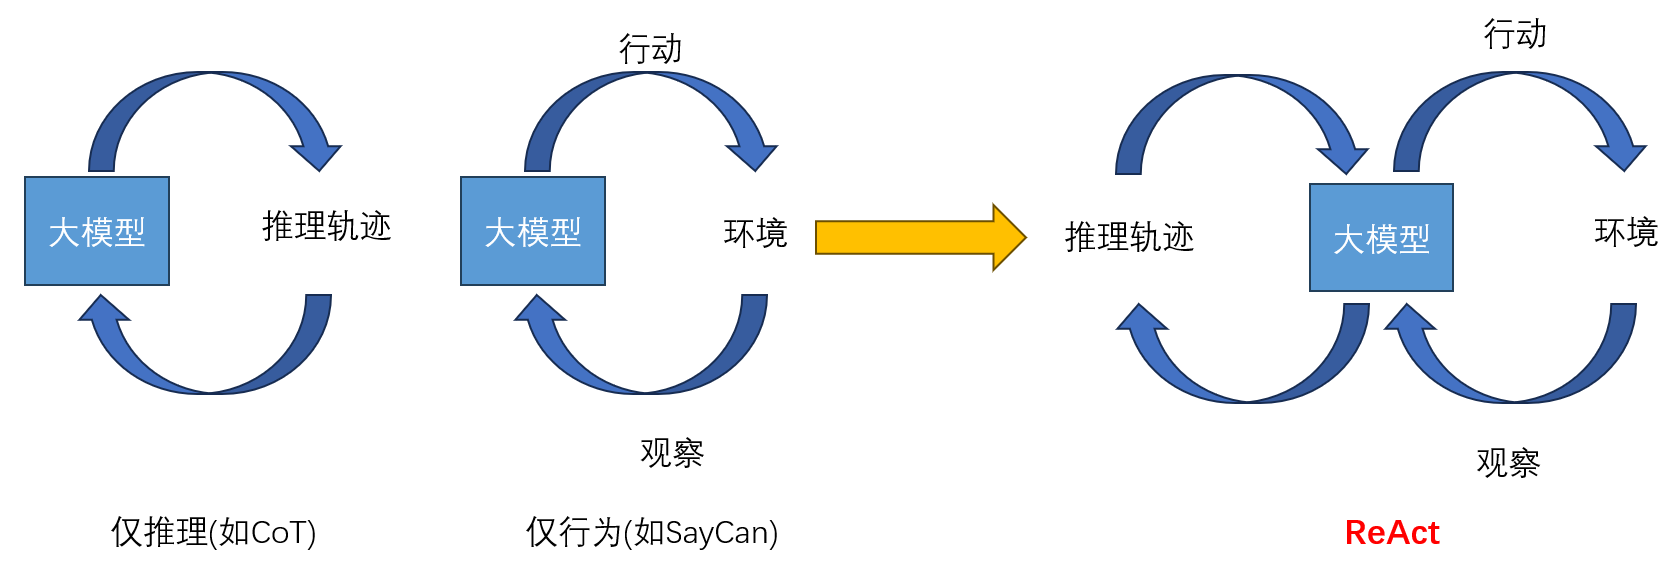
<center style="font-size:14px">图2.ReAct示意图</center> 


ReAct的具体流程可以分解为以下几个步骤：
1. 发起查询请求
2. LLM返回Thought和Action
3. 处理函数调用获取Observation
4. 把上下文信息以及函数调用结果发给LLM
5. LLM经过推理判断是否要继续调用函数或直接返回结果，若需要继续调用函数则返回2继续进行
6. LLM生成最终回复

一个典型的 ReAct 过程示例如下所示：

```yaml
Question: 一美元等于多少日元？

Thought: 我不知道当前汇率，应该先查一下。  
Action: SEARCH[一美元对日元汇率]  
Observation: 当前汇率为 157.5

Thought: 得到了汇率，现在可以计算。
Action: CALC[157.5 × 20]
Observation: 结果为 3150

Final Answer: 20美元约等于3150日元。
```


ReAct本质上还是prompt，只是对prompt的格式做了调整，有Thought ，Act，Obs这三个步骤。系统提示词可以参考langchain中的模板,在使用时需要记得修改prompt中的工具调用方式和工具调用示例为自己定义的格式，你可以将下面的模板翻译为中文版本的ReAct并根据自己的要求修改看看效果:

In [ ]:
"""
Answer the following questions as best you can. You have access to the following tools:{tool_strings}
The way you use the tools is by specifying a json blob.Specifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool going here).
The only values that should be in the "action" field are: {tool_names}
The \$JSON_BLOB should only contain a SINGLE action, do NOT return a list of multiple actions. Here is an example of a valid \$JSON_BLOB:
​```{{{{"action": \$TOOL_NAME,"action_input": \$INPUT}}}}```
ALWAYS use the following format:
Question: the input question you must answer
Thought: you should always think about what to do. 
Action:```$JSON_BLOB```.
Observation: the result of the action... (this Thought/Action/Observation can repeat N times)
Thought: I now know the final answer.
Final Answer: the final answer to the original input question
Begin! Reminder to always use the exact characters `Final Answer` when responding.
"""

这种方式通过人为引导的方式让模型“做出决策”，其优点是:
- 易于实现
- 对模型参数要求较低
- 推理过程可见，更高的可解释性

缺点是：
- 需要设置复杂的系统提示词，token消耗较多
- 输出结果处理比Function Calling复杂

适用于教学、小型智能体或不希望模型自由决策的场景。

ReAct 提供了一个结构化的、基于工具反馈的多轮 reasoning 框架。

### 7.4.3 工具的解析与执行

工具调用不是一句“Action: Tool[]”就结束了。 真正的智能体系统，还需要读懂调用指令，真正去做这件事，再把结果反馈回来。
在 ReAct 风格或 Function Calling 架构中，语言模型只是提出了“我需要工具A，参数是X”的请求。
但模型自身无法直接执行外部操作，因此必须有一个中间组件去解析与执行工具。

这个组件的职责是：

1. 解析模型生成的工具调用格式
2. 匹配对应的工具函数或 API 接口
3. 进行参数验证与执行调用
4. 收集结果并封装成 Observation，反馈给模型


#### 为什么“解析”如此关键？
语言模型输出的内容，本质上是自然语言或半结构化格式或者是更加复杂的结果，如：

In [ ]:
{
  "action": "search_weather",
  "args": {
    "city": "北京"
  }
}

我们必须保证：
- 模型的调用格式是语法合法的  
- 模型传入的参数是类型正确的  
- 工具名称是在注册表中存在的  
- 整个结构可以被程序可靠解析并运行  

否则，工具系统就会出现如下常见问题：
- 工具名拼错：searh / cacl / calcualte  
- 参数格式错乱：使用 [ ] 时括号不闭合，或 JSON 缺引号  
- 工具未注册：调用不存在的工具  
- 参数类型不符：传入了字符串但要求数字  

#### 如何构建一个稳健的“工具解析器”

一个标准的工具解析器应具备以下能力：

| 能力 | 实现方式 |
|------|----------|
| 工具名称识别与校验 | 检查工具名是否注册 |
| 参数提取与验证 | 提取参数并与工具接口说明进行类型校验 |
| 支持格式容错（如中英文括号） | 可选加载模糊匹配或容错转换逻辑 |
| 错误提示与重试机制 | 对错误调用返回 Observation 并建议改正 |

如果采用严格的输出格式和解析（如JSON格式）可提高大模型生成结果的可靠性。

示例 1：ReAct 模板中的调用解析：

比如下面的一个调用

Action: Calculator[157.5 * 20]

**解析步骤：**

1. 匹配出调用指令：`Calculator`
2. 提取参数内容：`157.5 * 20`
3. 执行对应函数：`eval('157.5 * 20') → 3150.0`
4. 返回 Observation：`结果为 3150.0`

示例 2：JSON 格式 Function Call 解析：

In [ ]:
{
  "name": "search_news",
  "arguments": {
    "query": "OpenAI发布了什么？"
  }
}

**解析方式：**

- 校验 tool name 是否注册为 search_news

- 提取参数字段并校验类型为 string

- 工具执行成功后，返回结构化的observation

#### 执行阶段的重点

| 问题类型       | 风险表现                      | 应对策略                         |
|----------------|-------------------------------|----------------------------------|
| 工具副作用     | 发邮件、控制硬件等敏感行为    | 权限管理、沙盒执行、模拟运行    |
| 执行中断或失败 | 参数报错、API timeout         | `try/except` 包装、自动 retry    |
| 调用后忽略结果 | `Observation` 被模型遗忘或误用 | 使用标准模板反馈结果             |
| 返回不规范     | 模型难以继续理解结果          | 使用结构化格式或关键词提醒模型  |


当工具调用失败（如网络错误、参数格式错误）时，引入重试机制可提升鲁棒性：

In [ ]:
for retry in range(max_retries):
    try:
        result = tool_fn(arg)
        break
    except Exception as e:
        result = f"[Error]: {e}"


在模型调用完工具后，必须看到明确、标准化的结果，以继续推理。建议采用统一格式，或使用结构化 JSON，如。

```text
Observation: 当前汇率为 157.5
```

统一的反馈结构，能够帮助模型更好地衔接后续 Thought、Action 步骤，避免逻辑断裂。



## 7.5 多工具整合与调度

随着语言模型功能增强和应用需求的提升，单一工具已难以应对复杂任务。例如，用户可能发出这样的请求：“查一下这家公司最近的股价走势，并告诉我这是否是个合适的投资时机。”这些任务往往涉及多个子目标、跨越多个领域，需要模型能够综合使用多个工具、顺序执行多个步骤、处理前后依赖关系，并应对可能的失败与回退。一个成熟的智能体需要面对的是**工具集合**（Tool Set），它包括了一系列不同功能的工具。

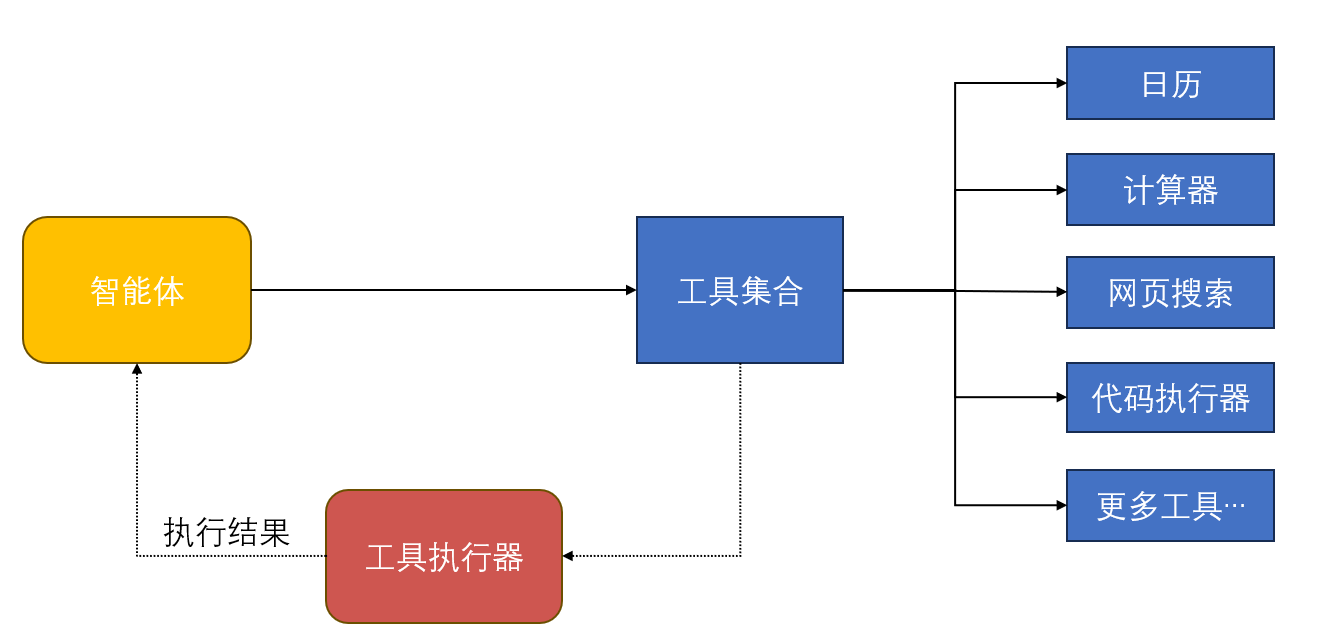
<center style="font-size:14px">图3.多工具整合示意图</center> 

在这种多工具环境中，模型不再是“要不要调用工具”，而是调用哪个工具、调用顺序是什么、失败时调用哪个。

因此，“多工具整合与调度”不仅是技术设计问题，更是智能体决策力的体现。本节将系统性回答以下问题：

- **何时调用哪个工具？**（多工具选择）
- **多个工具之间如何协作？**（顺序、组合、信息传递）
- **出错了怎么办？是否有备选？**（回退与鲁棒性）
- **如何让模型“自己决定”？是否需要辅助策略？**

这一议题的核心在于：赋予语言模型自主选择工具的能力，并保证整个工具链在执行过程中的可控性与连贯性。

接下来，我们将从多工具的选择方式出发，逐步分析调度逻辑、执行机制与策略建议，帮助你构建一个稳定、灵活、具备规划与恢复能力的多工具调用系*。


### 7.5.1 当工具多了，谁来决定用哪个？

一个关键问题是：**模型/智能体是如何决定使用哪个工具？**

我们可以从两类方式来构建工具调用策略：

#### 方式一：提示中提供工具列表，模型自主选择

这种方式可以让模型去自主选择。在提示词中提供工具列表，由模型根据上下文选择合适的工具。例如在system prompt中，可以加入这样的提示词：

In [ ]:
"""
你可以使用以下工具：
1. Search(query: str)
2. Calculator(expression: str)
3. Translate(text: str, to_lang: str)
"""

这种方式的优点是灵活性强，模型能够根据上下文理解任务需求并选择最合适的工具。同时易于扩展，只需在提示中添加新工具即可支持更多功能。此外能保留 LLM 的语义推理能力，配合 ReAct 模式更具智能性。但是，也存在许多缺点：依赖模型的理解与学习能力，对模型训练质量和提示设计要求较高，非常考验模型的指令遵循能力。在工具数量增加后，模型可能难以做出准确区分，出现混淆或误用。所以其适用场景应当是模型规模较大、具备较强上下文理解能力或强调智能体自主决策与规划的场景，如开放式问答、自动科研助理等。


#### 方式二：关键词触发路由
这种方式在 LLM 执行前加入一个关键词检测模块，用于扫描用户输入中的高频词、实体词或任务意图，然后自动映射到预设工具。例如：

- 用户输入包含“天气怎么样” → 路由至 WeatherAPI；

- 包含“是多少” → 路由至 Calculator；

- 包含“新闻” → 路由至 WebSearch。

此方式更像是一个“任务路由器”或“意图识别层”，可独立于语言模型之外运行，并作为前置步骤帮助系统更稳定地调度工具。
这种方式适合做前置过滤或与模型分工协作，提高调用成功率。

这种方式的优点是调用规则清晰、稳定性高；响应速度快。但也存在许多缺点
灵活性较差，无法处理语义模糊、上下文丰富的输入。扩展性受限：新工具加入需同步更新关键词路由规则。难以处理复杂推理任务（如多步问题、组合型调用）。此外由于现实中人类自然语言语义是相当丰富的，仅靠关键词检测就对句子判断目的很可能会出现目的不符合的问题。

### 7.5.2 多工具协作与顺序执行

复杂任务往往需要多个工具依次完成。例如：

> 问题：OpenAI 的最新发布会是哪天？它距离今天几天？

模型可以先调用 `search_news` 工具获取发布日期，再调用 `Calculator` 工具计算时间差。

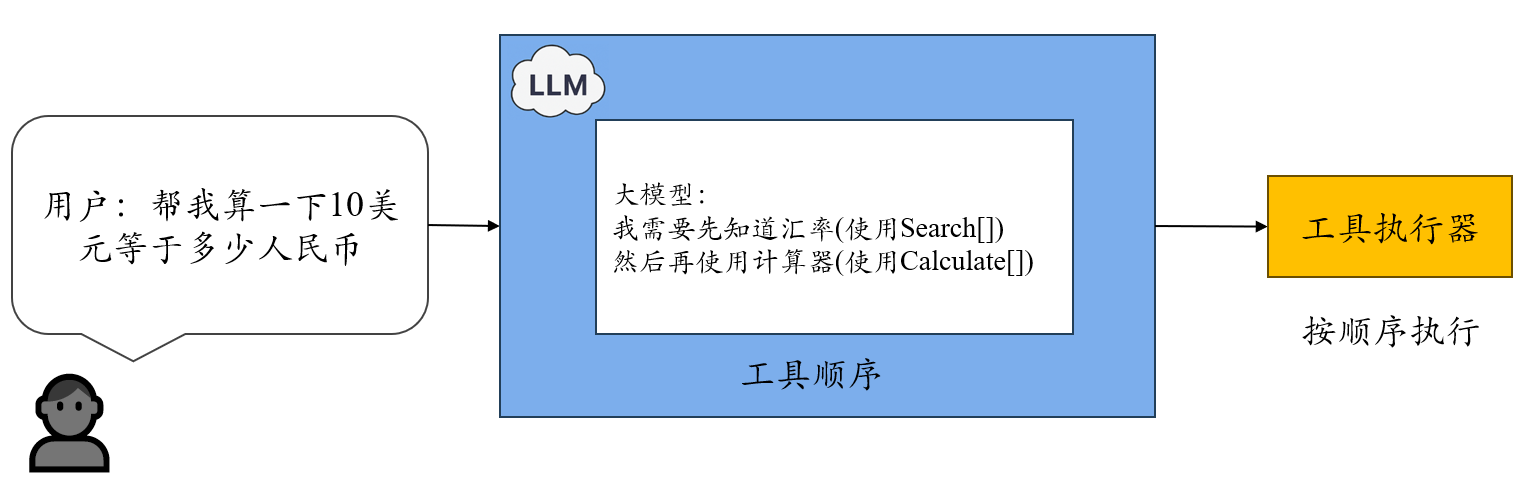
<center style="font-size:14px">图4.多工具顺序执行示意图</center> 



这一流程中涉及多个关键问题：

- **结果传递：** 工具 A 的结果是否能作为工具 B 的输入？
- **中间思考：** 是否需要 Thought 步骤帮助模型过渡？
- **格式兼容：** 不同工具的输出是否统一，是否需要结构化标准（如统一使用 Observation JSON）

建议通过设计统一的 Observation 反馈格式 + Thought 引导提示，帮助模型有序地组织多工具推理过程。

### 7.5.3 工具优先级与回退机制

在多工具环境中，智能体不仅需要知道“有哪些工具”，更需要具备工具调用顺序的判断力。换言之，面对某个问题，模型可能会：

- 优先调用某些成功率更高或代价更低的工具；
- 在工具失败时，及时切换至候补工具继续任务流程。

这正是“工具优先级”和“回退机制”设计的出发点。


#### 工具优先级

设想我们有如下几个工具：

- `WebSearch`: 实时网络搜索，信息最新但响应慢、结构化程度低；
- `InternalKB`: 内部知识库，响应快、结构清晰但内容有限；
- `FAQBot`: 常见问答机器人，适用于重复性强的问题；
- `Calculator`: 数学计算器，快速可靠但只能执行算术运算。

面对同一个问题：“ChatGPT 什么时候上线的？”，智能体可能的优先策略如下：
- 首选 InternalKB （若内部有记录）
- 若查不到，则尝试 FAQBot
- FAQ 仍查不到，再使用 WebSearch


这种策略，有助于提升系统整体效率，同时减少无效或高成本的工具调用。

#### 回退机制

即使选择了最合适的工具，也不可避免会遇到工具调用失败，如：

- 工具服务挂了（网络或 API 错误）；
- 参数格式不正确导致返回空；
- 模型误判任务需求导致工具选错。

此时，需要设计合理的容错回退机制，指导模型在观察失败后采取下一步行动。例如：

Thought: 我需要查询当前美元兑日元汇率  
Action: Search[1 USD to JPY]  
Observation: 抱歉，未能搜索到相关结果  
Thought: 搜索失败，我尝试使用备用工具获取汇率信息  
Action: ExchangeRateAPI[USD,JPY]

通过嵌套式思维与决策链条，模型可以自动回退到次优工具，维持任务连续性，避免逻辑中断。

### 7.5.4 策略建议：如何让多工具调用更加稳定？
在智能体系统日趋复杂的今天，我们更希望智能体能够精准判断任务需求，合理调用工具、稳健处理失败，构建跨工具的信息传递链。
为此，我们提供如下关键策略建议：

（1）先分类、再调用
我们可以在提示设计或外部调度逻辑中引入任务分类机制，预判断问句类型。例如：
- 对输入进行类型识别：是否包含数字、实体名、关键词；

- 专门训练一个分类器（可以使用如bert等模型），按照检索型，计算型，操作型分类；

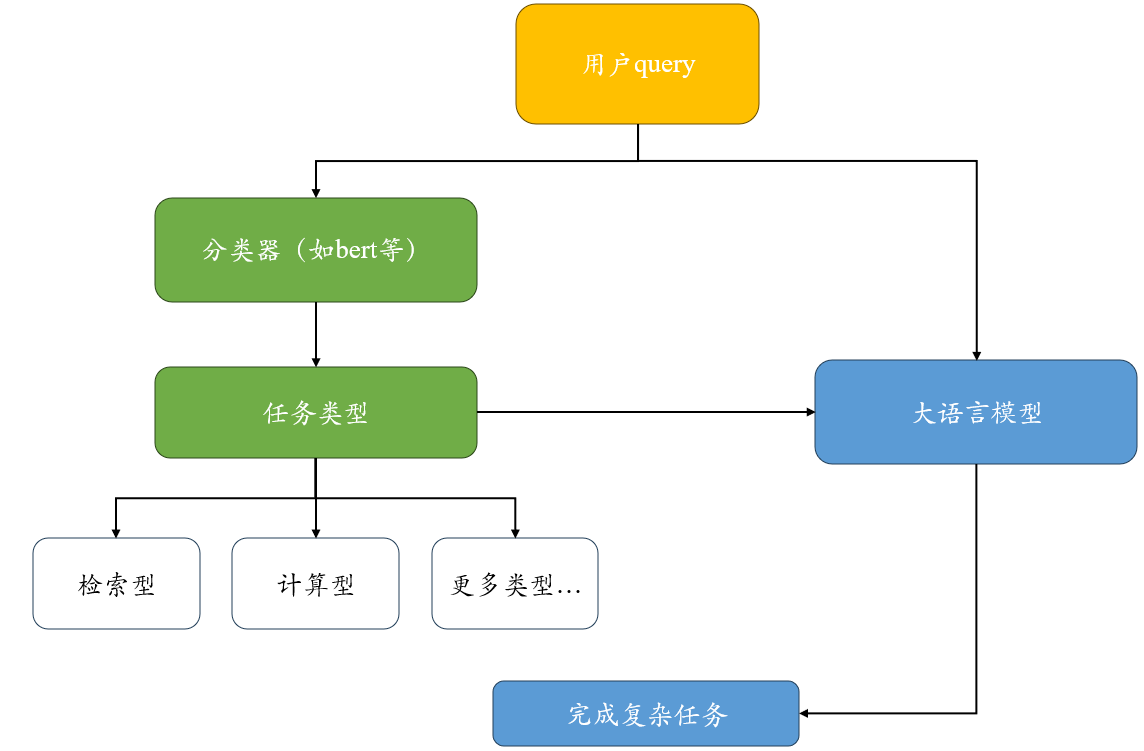
<center style="font-size:14px">图5.多工具调用策略</center> 


- 结合示例指令帮助模型自我归类。

这一步骤可提升工具选择准确率，并减少无用调用，但比较依赖分类机制的准确性和扩展性。

（2）多轮反馈机制
我们还可以鼓励模型使用反思之后再行动的结构。如果工具失败后不是直接终止，而是评估失败原因并改进下一步调用。这种结构本质上是让模型学会在不确定性环境中逐步优化，让模型试探式优化调用策略。

（3）设置调用限制，避免死循环
一个稳健系统还应包括步数限制或者是工具调用上限机制，防止模型进入无穷调用或工具误判死循环。例如：最大允许 3 次连续调用工具，若仍失败则 fallback 到通用答复。之后让智能体进行处理，包括换用其他工具或者给出最终答复。




综上，一个健壮的多工具智能体系统，应兼顾灵活性、可控性与容错性，通过工具优先级、回退机制、提示工程与结构化反馈设计，提升任务完成率与用户体验。

## 7.6 实战：多能力智能体

In [ ]:
# 安装必要依赖
!pip install langchain openai python-dotenv langchain-experimental numexpr
!pip install serp
# 导入基础库
import os
from dotenv import load_dotenv


2. 初始化模型

In [2]:
from langchain.chat_models import ChatOpenAI

# 使用Deepseek API
llm = ChatOpenAI(
    model_name="deepseek-chat", 
    openai_api_base="https://api.deepseek.com/v1",  # Deepseek API端点
    openai_api_key="sk-2ad88b35e31c44a99830ffc9e1c1465b",  # 替换为你的Deepseek API密钥
    temperature=0.7,
    max_tokens=500
)

test_response = llm.predict("你好呀")
print(test_response)

/tmp/ipykernel_205255/2731079040.py:4: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
/tmp/ipykernel_205255/2731079040.py:12: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  test_response = llm.predict("你好呀")


你好呀！😊 很高兴见到你～今天有什么想聊的或者需要帮忙的吗？无论是闲聊、问题解答，还是想分享有趣的事，我都在这里哦！✨


3. 创建备选工具集合

In [5]:
from langchain.tools import Tool
from langchain_experimental.utilities import PythonREPL
import requests

# 计算器
def calculator(expression: str) -> str:
    try:
        result = eval(expression)
        return f"计算结果为 {result}"
    except Exception as e:
        return f"计算错误出现错误，请重试"

# 时钟
from datetime import datetime

def get_current_time(query: str) -> str:
    now = datetime.now()
    return f"当前时间为 {now.strftime('%Y-%m-%d %H:%M:%S')}"

# 搜索引擎,使用百度
from langchain.utilities import SerpAPIWrapper
search_api_baidu = SerpAPIWrapper(params={"engine": "baidu"},serpapi_api_key="12fcd3c5a9dd5dc3a9e9cd080272b6b5bee2c3ce9823624616eb63e868bcdcdd")  

def search_engine_baidu(query: str) -> str:
    search_result = search_api_baidu.run(query)
    if isinstance(search_result,str):
        return search_result
    elif isinstance(search_result,list):
        return search_result[0]

# 搜索引擎,使用Google
search_api_google = SerpAPIWrapper(params={"engine": "google"},serpapi_api_key="12fcd3c5a9dd5dc3a9e9cd080272b6b5bee2c3ce9823624616eb63e868bcdcdd")  

def search_engine_google(query: str) -> str:
    search_result = search_api_google.run(query)
    if isinstance(search_result,str):
        return search_result
    elif isinstance(search_result,list):
        return search_result[0]
        
# 网页内容抓取
def get_web_content(url: str) -> str:
    try:
        response = requests.get(url, timeout=10)
        return response.text[:2000]
    except Exception as e:
        return f"无法访问网页: {str(e)}"

# 将函数转化为langchain中的tool格式
calc_tool = Tool(
    name="Calculator",
    func=calculator,
    description="输入数学表达式并进行数学计算"
)
time_tool = Tool(
    name="CurrentTime",
    func=get_current_time,
    description="获取当前日期和时间"
)
search_tool_baidu = Tool(
    name="SearchBaidu",
    func=search_engine_baidu,
    description="使用百度根据输入进行实时网页搜索"
)

search_tool_google = Tool(
    name="SearchGoogle",
    func=search_engine_google,
    description="使用Google根据输入进行实时网页搜索"
)
web_content_tool = Tool(
    name="WebContentFetcher",
    func=get_web_content,
    description="获取指定URL的网页内容"
)
# 创建工具列表
tools = [calc_tool, time_tool,search_tool_baidu,search_tool_google,web_content_tool]

print("工具创建完成")
for tool in tools:
    print(f"- {tool.name}: {tool.description}")

工具创建完成
- Calculator: 输入数学表达式并进行数学计算
- CurrentTime: 获取当前日期和时间
- SearchBaidu: 使用百度根据输入进行实时网页搜索
- SearchGoogle: 使用Google根据输入进行实时网页搜索
- WebContentFetcher: 获取指定URL的网页内容


4. 创建系统提示模板和智能体

In [13]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain.prompts import PromptTemplate

# 修复后的提示词模板
prompt_template = """
你是一个有用的AI助手。尽你所能回答以下问题。你可以访问以下工具：{tools}

可用工具名称: {tool_names}

使用以下格式回答:
工具调用一次应该只包含一个操作，不要一次返回多个操作。

始终使用以下格式：
Question: 您必须回答的输入问题
Thought: 你应该始终思考如何回答问题
Action: 要使用的工具名称
Observation: 工具返回的结果。..（这个想法/行动/观察可以重复N次）
Thought: 我现在知道最后的答案了。
Final Answer: 原始输入问题的最终答案


Question: {input}
Thought:{agent_scratchpad}
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["tools", "tool_names", "input","agent_scratchpad"]
)

# 创建ReAct Agent
agent = create_react_agent(llm, tools, prompt)

# 创建Agent执行器
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=10, # 最大迭代次数为10秒
    max_execution_time=60  # 设置最大执行时间为60秒
)

print("智能体创建完成!")

智能体创建完成!


5. 使用智能体

In [18]:
def chat_with_agent(user_input: str):
    """与智能体对话的，自动调用工具"""
    try:
        response = agent_executor.invoke({"input": user_input})
        return response["output"]
    except Exception as e:
        return f"抱歉，处理您的请求时出现错误: {str(e)}"
test_questions = [
    "十美元等于多少日元？精确一点"
]

print("对话开始:")
print("=" * 50)

for i, question in enumerate(test_questions, 1):
    print(f"用户: {question}")
    print(f"助手: {chat_with_agent(question)}")
    print("-" * 30)

对话开始:
用户: 十美元等于多少日元？精确一点


> Entering new AgentExecutor chain...
Thought: 我需要获取当前的美元对日元的汇率，然后计算10美元等于多少日元。可以使用搜索引擎查找最新的汇率信息。

Action: SearchGoogleInvalid Format: Missing 'Action Input:' after 'Action:'I need to correct the format and include the specific search query for the current USD to JPY exchange rate.

Action: SearchGoogle
Action Input: "current USD to JPY exchange rate"144.88 Japanese YenNow that I have the current exchange rate (1 USD = 144.88 JPY), I can calculate how much 10 USD is in JPY.

Action: Calculator
Action Input: 10 * 144.88计算结果为 1448.8我现在知道最后的答案了。
Final Answer: 根据当前汇率，10美元等于1448.8日元（1美元=144.88日元）。

> Finished chain.
助手: 根据当前汇率，10美元等于1448.8日元（1美元=144.88日元）。
------------------------------


## 小结
在本章中，我们系统讲解了大语言模型如何借助外部工具扩展其能力边界。通过引入信息检索、计算执行、设备控制等多类型工具，智能体可以突破静态知识的限制，具备获取实时信息、精确计算和现实操作的能力。我们还讨论了工具接口设计、调用机制、指令执行流程以及多工具整合与调度策略，为构建多能力智能体打下了坚实基础。最终的实战项目帮助读者掌握了如何构建一个具备网络搜索与计算能力的智能问答系统，是本章知识的全面应用。

## 课后习题
习题1：对比理解

问题：请简述为什么仅靠大语言模型难以胜任实时信息问答？请举两个实际例子说明。

参考答案：

大语言模型知识是静态的，无法实时访问最新信息。例如：
问“当前美元兑日元汇率是多少”，LLM可能给出过时结果。调用网页搜索API可解决此类问题。

</br>

习题2：工具选择判断题
问题：判断下列问题是否必须使用工具，并说明原因。

1）“牛顿第二定律是什么？”

2）“帮我算一下今天是农历几号？”

3）“谁是2024年奥斯卡最佳男主角？”

参考答案：

1）不一定，模型可直接回答（已知知识）；

2）需要，需动态查询日历API；

3）最好调用工具，因为为时效性问题，模型知识可能过时。

</br>

习题3：请将以下任务匹配到合适的工具类型：

1）计算 $12345678 \times 987654321$

2）查找“世界上人口最多的国家”

3）控制灯泡开关

4）生成一段Python代码并运行输出结果

参考答案：

1）计算类工具（如CALC）；

2）信息检索类工具（如搜索引擎）；

3）设备控制类工具（如IoT控制器）；

4）计算类工具（如代码执行器）。

</br>

习题4：请设计一个合理的prompt，使模型能正确使用如下两个工具：

SEARCH[关键词]：执行搜索
CALC[表达式]：执行计算

参考答案（无标准答案，可以参考ReAct的提示）：

你可以使用以下两种工具：
- 如果你需要查找信息，请使用 SEARCH[关键词]；
- 如果你需要进行数学运算，请使用 CALC[表达式]。
请根据需要选择工具并格式化输出结果。

</br>

习题5：某模型面对用户提问“请问明天北京的天气如何？”时，回答为“明天北京天气晴，25°C”，但未使用任何工具。这种情况可能存在哪些问题？你将如何改进？

参考答案：

问题在于模型未调用天气API获取实时数据，使用了静态记忆。改进方式包括：

增加提示词，强制要求遇到“天气”类问题调用 SEARCH；

提升模型的ReAct能力，让其学会何时信息不足需调用工具；

增加判断模块，检测回答是否缺乏外部支撑信息。



## 参考文献  
1. Qin Y, Liang S, Ye Y, et al. Toolllm: Facilitating large language models to master 16000+ real-world apis[J]. arXiv preprint arXiv:2307.16789, 2023.

2. Achiam J, Adler S, Agarwal S, et al. Gpt-4 technical report[J]. arXiv preprint arXiv:2303.08774, 2023. 

3. Parisi et al. (2022). "Tool Augmented Language Models", arXiv:2205.01817.

4. Schick et al. (2023). "Toolformer: Language Models Can Teach Themselves to Use Tools", *NeurIPS* 2023.

5. Shen et al. (2023). "HuggingGPT: Solving AI Tasks with ChatGPT and HuggingFace", *NeurIPS* 2023.

6. Wei et al. (2022), "Chain-of-Thought Prompting Elicits Reasoning in LMs", NeurIPS 2022.

7. Yao et al. (2022). "ReAct: Synergizing Reasoning and Acting in Language Models", *ICML* 2022.

8. Liu A, Feng B, Xue B, et al. Deepseek-v3 technical report[J]. arXiv preprint arXiv:2412.19437, 2024.

9. Parisi A, Zhao Y, Fiedel N. Talm: Tool augmented language models[J]. arXiv preprint arXiv:2205.12255, 2022.

10. Hao S, Liu T, Wang Z, et al. Toolkengpt: Augmenting frozen language models with massive tools via tool embeddings[J]. Advances in neural information processing systems, 2023

11. Huang Y, Shi J, Li Y, et al. Metatool benchmark for large language models: Deciding whether to use tools and which to use[J]. arXiv preprint arXiv:2310.03128, 2023.